# Classifying Benign vs Malignant Melanoma
# Josiah Chung

In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from tqdm import tqdm

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

2023-05-21 17:11:34.920875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 17:11:39.488906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 17:11:39.488938: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-21 17:11:49.560933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.11.0


2023-05-21 17:11:55.437220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-21 17:11:55.469976: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-21 17:11:55.470042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20230515-112248): /proc/driver/nvidia/version does not exist


## Set seed for the project

In [2]:
np.random.seed(5463078)

## Importing Data

I collected about 24,000 images of benign and malignant melanoma from patients ranging from ages 20-50. 

You can view the gallery of images at the following link to the International Skin Imaging Collaboration Archive: https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery?filter=%5B%5D

In [3]:
from google.cloud import storage
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [4]:
# Create a client instance
storage_client = storage.Client()

# Specify the bucket name and folder paths
bucket_name = 'msca-ml-skin-images'
benign_folder_path = 'Data/Benign'
malignant_folder_path = 'Data/Malignant'

# Get a reference to the bucket
bucket = storage_client.get_bucket(bucket_name)

I tested some resizing and looked at some images with a 224x224 transformation and the resolution appeared to be good enough to effectively categorize between benign and malignant melanoma. I printed out some images of both benign and malignant below.

#### Benign example images

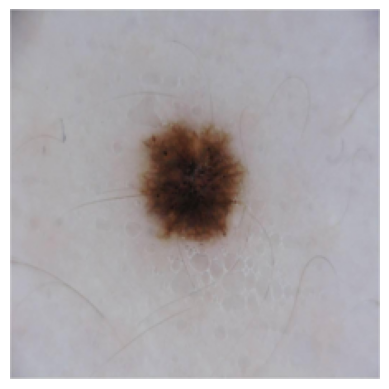

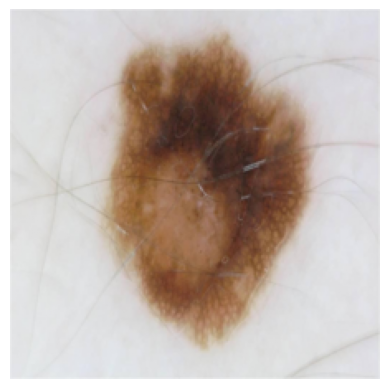

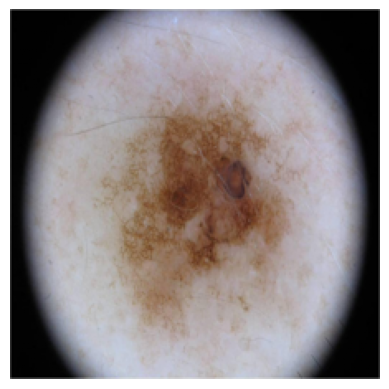

In [5]:
# Load and display some benign images

benign_blobs = bucket.list_blobs(prefix=benign_folder_path)
num_benign_loaded = 0

for blob in benign_blobs:
    if blob.name.endswith('.JPG') and num_benign_loaded < 3:  # Adjust the file extension and number of images as needed
        # Download the image blob
        blob.download_to_filename('/tmp/temp.jpg')
        
        # Open and process the image
        img = Image.open('/tmp/temp.jpg')
        img = img.resize((224, 224))  # Adjust the image size as per your requirements
        img = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
        
        # Display the loaded image
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        num_benign_loaded += 1

#### Malignant example images

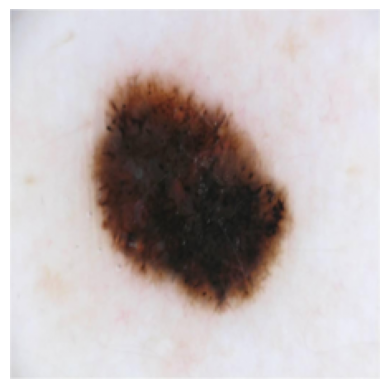

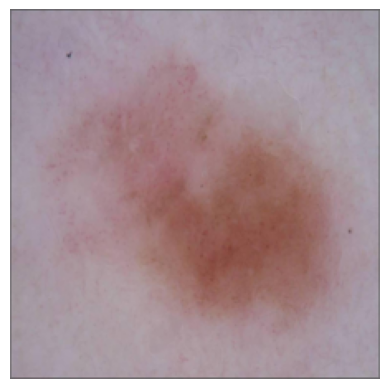

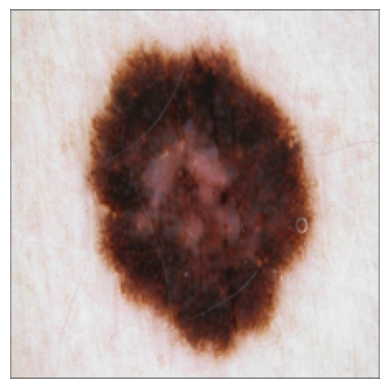

In [6]:
# Load and display some malignant images

malignant_blobs = bucket.list_blobs(prefix=malignant_folder_path)
num_malignant_loaded = 0

for blob in malignant_blobs:
    if blob.name.endswith('.JPG') and num_malignant_loaded < 3:  # Adjust the file extension and number of images as needed
        # Download the image blob
        blob.download_to_filename('/tmp/temp.jpg')
        
        # Open and process the image
        img = Image.open('/tmp/temp.jpg')
        img = img.resize((224, 224))  # Adjust the image size as per your requirements
        img = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
        
        # Display the loaded image
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        num_malignant_loaded += 1

### Initial Considerations and Dealing with Class Imbalance

I downloaded and had about 22,000 benign and 1,300 malignant images on hand. To deal with this imbalance, I decided to use a combination of data augmentation on the malignant images and undersampling of the benign images.

I decided on having 5,000 benign and 5,000 malignant images. This decision was mostly based on the limitation of the malignant images. I thought data augmentation to generate a ratio of more than 5:1 augmented images would risk overfitting. Additionally, It turned out that a total of about 10,000 224x224x3 images was about the best I was able to work with in terms of my computational limitations as well as time constraints.

In [7]:
# Set up empty lists

benign_images = []
malignant_images = []

### Undersampling Benign Images

To reduce the number of benign images from about 22,000 to 5,000 images, I shuffled the bucket where the benign images were located then imported the first 5,000 images from that bucket. I applied some transformations onto the images including shearing, zooming, and flipping. I decided that all three of these transformations would be fitting to apply to these images, as the way melanoma looks can vary, and I would want to develop a model that could account for such variation.

Additionally, as done earlier on, I rescaled the images to 224x224 as well as normalized the pixel values.

In [8]:
# Set the number of images to import
data_count = 5000

# Create an instance of ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Count the total number of images
total_images = sum(1 for _ in bucket.list_blobs(prefix='Data/Benign/') if _.name.endswith('.JPG'))

# Shuffle the list of benign blobs
benign_blobs = shuffle(list(bucket.list_blobs(prefix='Data/Benign/')))

# Load benign images
with tqdm(total=data_count, desc='Loading Benign Images') as pbar:
    for i, blob in enumerate(benign_blobs):
        if i >= data_count:
            break
        if blob.name.endswith('.JPG'):
            # Download the image blob
            blob.download_to_filename('/tmp/temp.jpg')

            # Open and process the image
            img = Image.open('/tmp/temp.jpg')
            img = img.resize((224, 224))
            
            # Apply transformations using ImageDataGenerator
            img = datagen.random_transform(np.array(img))
            
            img = img / 255.0  # Normalize pixel values between 0 and 1
            benign_images.append(img)

            # Update the progress bar
            pbar.update(1)

# Close the progress bar
pbar.close()

Loading Benign Images: 100%|██████████| 5000/5000 [15:10<00:00,  5.49it/s]


### Data Augmentation/Oversampling of Malignant Images

For the Malignant Images, I first imported the original ~1300 images without any kind of transformations other than rescaling and normalization.

In [9]:
# Count the total number of images
total_images = sum(1 for _ in bucket.list_blobs(prefix=f'Data/Malignant/') if _.name.endswith('.JPG'))

# Load malignant images
with tqdm(total=total_images, desc='Loading Malignant Images') as pbar:
    for i, blob in enumerate(bucket.list_blobs(prefix=f'Data/Malignant/')):
        if blob.name.endswith('.JPG'):
            # Download the image blob
            blob.download_to_filename('/tmp/temp.jpg')

            # Open and process the image
            img = Image.open('/tmp/temp.jpg')
            img = img.resize((224, 224))
            img = np.array(img) / 255.0  # Normalize pixel values between 0 and 1
            malignant_images.append(img)

            # Update the progress bar
            pbar.update(1)

# Close the progress bar
pbar.close()

Loading Malignant Images: 100%|██████████| 1373/1373 [02:17<00:00,  9.97it/s]


Then I started generating new images and adding them to the malignant image pool until I reached 5,000 images. To generate new images, I obtained a random image from the original set of malignant images and applied the same transformations done on the benign images to the malignant image (shear 0.2, zoom 0.2, horizontal flip).

In [10]:
# Define the number of additional images to generate
target_count = 5000
original_count = len(malignant_images)
additional_count = target_count - original_count

# Perform data augmentation on the original images
augmented_images = malignant_images[:original_count]  # Keep the original images

# Generate additional augmented images
with tqdm(total=additional_count, desc='Generating Augmented Images') as pbar:
    for i in range(additional_count):
        # Randomly select an original image
        original_img = malignant_images[i % original_count]

        # Apply random transformations to the original image
        augmented_img = datagen.random_transform(original_img)

        # Add the augmented image to the list
        augmented_images.append(augmented_img)

        # Update the progress bar
        pbar.update(1)

# Convert the list of augmented images to a NumPy array
malignant_images = np.array(augmented_images)

Generating Augmented Images: 100%|██████████| 3627/3627 [00:36<00:00, 99.10it/s] 


Now we have a balanced dataset.

In [11]:
# Convert the image lists to NumPy arrays
benign_images = np.array(benign_images)
malignant_images = np.array(malignant_images)

In [12]:
print("Number of Benign Images:", len(benign_images))
print("Number of Malignant Images:", len(malignant_images))

Number of Benign Images: 5000
Number of Malignant Images: 5000


## Train and Test Split

Normally with a relatively larger pool of images (10,000), I would have wanted to set a test portion size of about 15 or 20 percent. However, because I already oversampled so many images from the malignant images, I want to reduce the risk of overfitting and keep the test portion size at 30 percent instead.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Concatenate benign and malignant images into a single array
all_images = np.concatenate((benign_images, malignant_images), axis=0)

# Create labels for the images (0 for benign, 1 for malignant)
labels = np.concatenate((np.zeros(len(benign_images)), np.ones(len(malignant_images))), axis=0)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.3, random_state=5463078)

In [15]:
# Clearing up some memory
all_images = []
malignant_images = []
benign_images = []

## Modeling

I decided to utilize transfer learning to create a model. I tested the effectiveness of two pre-trained models with my data: Resnet50 and VGG16. To decide which model to use, I tried running both models with the same set of custom layers and compared their performances.

Specifically, the layers I chose for this test was:
- A Dense layer with 256 units and a 'relu' activation function
- A Dropout layer with a rate of 0.5
- A final Dense layer with 1 unit and a 'sigmoid' activation function, in order to facilitate a binary output.

In [39]:
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import scikeras
from scikeras.wrappers import KerasClassifier

### Trying Resnet50

In [17]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50
import cv2, numpy as np

In [18]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in resnet_model.layers:
    layer.trainable = False

2023-05-21 17:30:34.029172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Create a new model
model_r = Sequential()

# Add the ResNet50 model as a layer
model_r.add(resnet_model)

# Flatten the output of the ResNet50 model
model_r.add(Flatten())

# Custom Layers
model_r.add(Dense(256, activation='relu'))
model_r.add(Dropout(0.5))
model_r.add(Dense(1, activation='sigmoid'))

# Compile
model_r.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model_r.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
model_r.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

2023-05-21 17:30:40.669785: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4214784000 exceeds 10% of free system memory.


Epoch 1/3
219/219 [==============================] - 225s 1s/step - loss: 1.1528 - accuracy: 0.5150 - val_loss: 0.6925 - val_accuracy: 0.5390
Epoch 2/3
219/219 [==============================] - 218s 996ms/step - loss: 0.6956 - accuracy: 0.5119 - val_loss: 0.6934 - val_accuracy: 0.4870
Epoch 3/3
219/219 [==============================] - 217s 993ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6934 - val_accuracy: 0.4870


In [22]:
# Evaluate the model on the test set
loss, accuracy = model_r.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

94/94 [==============================] - 62s 659ms/step - loss: 0.6934 - accuracy: 0.4870
Test Loss: 0.6933825016021729
Test Accuracy: 0.4869999885559082


In [23]:
# Clearing memory
model_r = []

### Trying VGG16

In [24]:
vgg_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in vgg_model.layers:
    layer.trainable = False

In [25]:
# Create a new model
model_v = Sequential()

# Add the VGG16 model as a layer
model_v.add(vgg_model)

# Flatten the output of the VGG16 model
model_v.add(Flatten())

# Add your custom classifier layers
model_v.add(Dense(256, activation='relu'))
model_v.add(Dropout(0.5))
model_v.add(Dense(1, activation='sigmoid'))

# Compile the model
model_v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model_v.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
model_v.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3


2023-05-21 17:42:52.040956: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4214784000 exceeds 10% of free system memory.


219/219 [==============================] - 581s 3s/step - loss: 0.6084 - accuracy: 0.7157 - val_loss: 0.5029 - val_accuracy: 0.7467
Epoch 2/3
219/219 [==============================] - 576s 3s/step - loss: 0.5031 - accuracy: 0.7631 - val_loss: 0.4782 - val_accuracy: 0.7657
Epoch 3/3
219/219 [==============================] - 575s 3s/step - loss: 0.4826 - accuracy: 0.7699 - val_loss: 0.4709 - val_accuracy: 0.7737


In [28]:
# Evaluate the model on the test set
loss, accuracy = model_v.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

94/94 [==============================] - 173s 2s/step - loss: 0.4709 - accuracy: 0.7737
Test Loss: 0.47093337774276733
Test Accuracy: 0.7736666798591614


As evident in the above code, the VGG16 Model far outperformed Resnet50. VGG16 gave an accuracy of about 77%, whereas the accuracy of Resnet50 was only about 49%.

After evaluating these accuracy numbers, I decided to use VGG16 as the base layer of my model and begin hyperparameter tuning via random search.

## Random Search with Selected Model:
Built using transfer learning; VGG16 Model as first layers

Custom Layers:
- Dense Layer
- Dropout Layer
- Dense Layer 1 Unit Sigmoid Activation Function
    
For the range of possible dense units for my random search, I incremented between 128 and 512 with steps of 64. I had a feeling that the model performance would improve with more parameters because it would allow for more complex interpretation of the image.

For the dropout layer, I had a feeling that my model performance would improve with a smaller dropout value, so I set the potential random search dropout rates to be between 0.1 and 0.5 with steps of 0.1. My intuition was telling me that all the benign and malignant images can look so different, so setting a dropout rate too high could possibly hurt the model's capability to recognize a diverse range of images.

I chose to use an Adam optimizer and the specific learning rate values that I chose largely because those just seem to be popular choices with deep learning and CNNs, but I also used this website for guidance when performing the random search:

https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/

My code deviates from this tutorial in quite a few ways, most notably the addition of a dropout layer in my model function, using different hyperparameter values, and changing the loss function to `binary_crossentropy` due to the purpose of my model.

I also scaled back the tuning compared to the tutorial, reducing the number of trials and the number of epochs per trial due to both time and computing constraints.

In [40]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import make_classification
import keras_tuner
from keras_tuner.tuners import RandomSearch

In [30]:
def build_model(hyp):
    model = keras.Sequential([
    
    # put down VGG16 model down first
    vgg_model,
    
    # Flatten the output for VGG16 model
    keras.layers.Flatten(),
    
    # Add a variable dense layer
    keras.layers.Dense(
        units=hyp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'),
    
    # Add a Droupout Layer
    keras.layers.Dropout(
        rate=hyp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
    
    # Add final Dropout layer with sigmoid activation function for binary classification
    keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(hyp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [31]:
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 7)

In [32]:
tuner.search(X_train,y_train, epochs=3, validation_data=(X_train,y_train))

Trial 7 Complete [00h 40m 58s]
val_accuracy: 0.7638571262359619

Best val_accuracy So Far: 0.8304286003112793
Total elapsed time: 04h 47m 14s
INFO:tensorflow:Oracle triggered exit


In [41]:
best_model=tuner.get_best_models(num_models=1)[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'dense_units': 512, 'dropout_rate': 0.1, 'learning_rate': 0.01}


In [43]:
# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

94/94 [==============================] - 173s 2s/step - loss: 0.4709 - accuracy: 0.7830
Test Loss: 0.4708724915981293
Test Accuracy: 0.7829999923706055


So it did indeed turn out that increasing the units in the first dense layer, as well reducing the dropout rate did improve the performance of my model. I got a final accuracy of 0.7830.

## Overfitting considerations

I took numerous precautions to try and avoid overfitting my data such as implementing a dropout rate into my model, as well as limiting the epoch sizes on which my data was trained on. 

To verify, the `val_accuracy` of the model fit to the train data vs test data was 0.8304 vs 0.7830 respectively. This similarity in accuracy indicates that there was likely not significant overfitting occuring in my model.

## Lessons Learned and Future Work

### Computational Speed

It was not until I worked on this project that I experienced first-hand why computational efficiency is so important. Working with image data brought the scale of this project to a level that I had not worked on before, which caused some challenges working on this project. One thing I think could have been improved about my project was that I could have processed the image in batches, which could have allowed for me to import more images to work with. I had to scale down 24,000 images to about 10,000 images, because my code and machine could not handle the larger amount.

### Transfer Learning

I found it interesting that the VGG16 model performed so much better than the Resnet50 model. Additionally, although I did not include it in this code, I tested a very simple model with only two convolutional layers, and it only performed slightly worse than the VGG16 model. I had originally assumed that the larger parameter size of the VGG16 model is what gave it the advantage, but maybe there was something else with the structure of the Resnet50 that made it a worse alternative. 

### Future Work

I think there were a lot of limitations to my project that would be exciting to explore in the future.

1. Image Limitations
- If I had used all of the images from the International Skin Imaging Collaboration Archive, I could have had about 60 to 70 thousand images to train my models on. Utilizing a larger dataset could definitely be an area of improvement in the future. 
- My data was also incredibly imbalanced. I had to use data augmentation on my malignant images, which may or may not have impacted the accuracy of my results. I also greatly reduced my pool of benign images to balance the data, but having more benign images could have improved the training of my model.

2. More Extensive Exploration
- My random search could have been more extensive. I could have explored more hyperparameters and ran the search for a larger number of trials.
- I could have also tested more layers and tested more pre-trained models for transfer learning.
